In [1]:
import geopandas as gpd
import geoai


In [2]:
satellite_imagery = './pabbi_satellite_image_COG.tif'
vector_file = './pabb_crop_V3.geojson'

In [9]:

gdf = gpd.read_file(vector_file)

print(f"Total Number of Parcels {len(gdf)}")

print(f"Number of Parcels with values (other than null): {gdf['Landuse_Ma'].notna().sum()}")

print(f"Details of Crop are : {gdf['Landuse_Ma'].value_counts()}")

Total Number of Parcels 7012
Number of Parcels with values (other than null): 6515
Details of Crop are : Landuse_Ma
Agriculture     5759
Stream           302
Other            229
Road/Streets     172
Graveyard         29
Built up          24
Name: count, dtype: int64


# Setting Class Ids for Land use Before generating Raster

In [10]:
label_map = {
    'Agriculture': 1,
    'Stream': 2,
    'Other': 3,
    'Road/Streets': 4,
    'Graveyard': 5,
    'Built up': 6
}

gdf['class_id'] = gdf['Landuse_Ma'].map(label_map)

gdf = gdf[gdf['class_id'].notna()]
gdf['class_id'] = gdf['class_id'].astype('uint8')
gdf=gdf.to_crs('EPSG:4326')
print(gdf.crs)

EPSG:4326


In [11]:
print(gdf['class_id'].unique())
print(gdf['class_id'].isnull().sum())
print(gdf['class_id'].dtype)


[1 6 2 4 5 3]
0
uint8


In [13]:
# Writing to temporary file
gdf.to_file('temp_cleaned_vector.geojson')

In [15]:
import rasterio
from rasterio.features import rasterize
#import geopandas as gpd
import numpy as np

# Load vector data and reproject
vector_path = "temp_cleaned_vector.geojson"  # Or your original GeoJSON/GeoPackage
vector = gpd.read_file(vector_path)

# Open the satellite raster as reference
with rasterio.open(satellite_imagery) as src:
    raster_meta = src.meta.copy()
    transform = src.transform
    out_shape = (src.height, src.width)
    crs = src.crs

# Ensure CRS matches
vector = vector.to_crs(crs)

# Prepare shapes: list of (geometry, class_id)
shapes = [(geom, value) for geom, value in zip(vector.geometry, vector['class_id'])]

# Rasterize
label_raster = rasterize(
    shapes=shapes,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Save raster
raster_meta.update({
    "count": 1,
    "dtype": 'uint8',
    "nodata": 0
})

output_path = "Labelraster_Manual.tif"
with rasterio.open(output_path, "w", **raster_meta) as dest:
    dest.write(label_raster, 1)

# Check output
print("✅ Raster written:", output_path)
print("Unique class values:", np.unique(label_raster))


✅ Raster written: Labelraster_Manual.tif
Unique class values: [0 1 2 3 4 5 6]


Reprojecting vector data from EPSG:32642 to EPSG:4326
Rasterized data saved to Labelraster_For_Unet_v4.tif


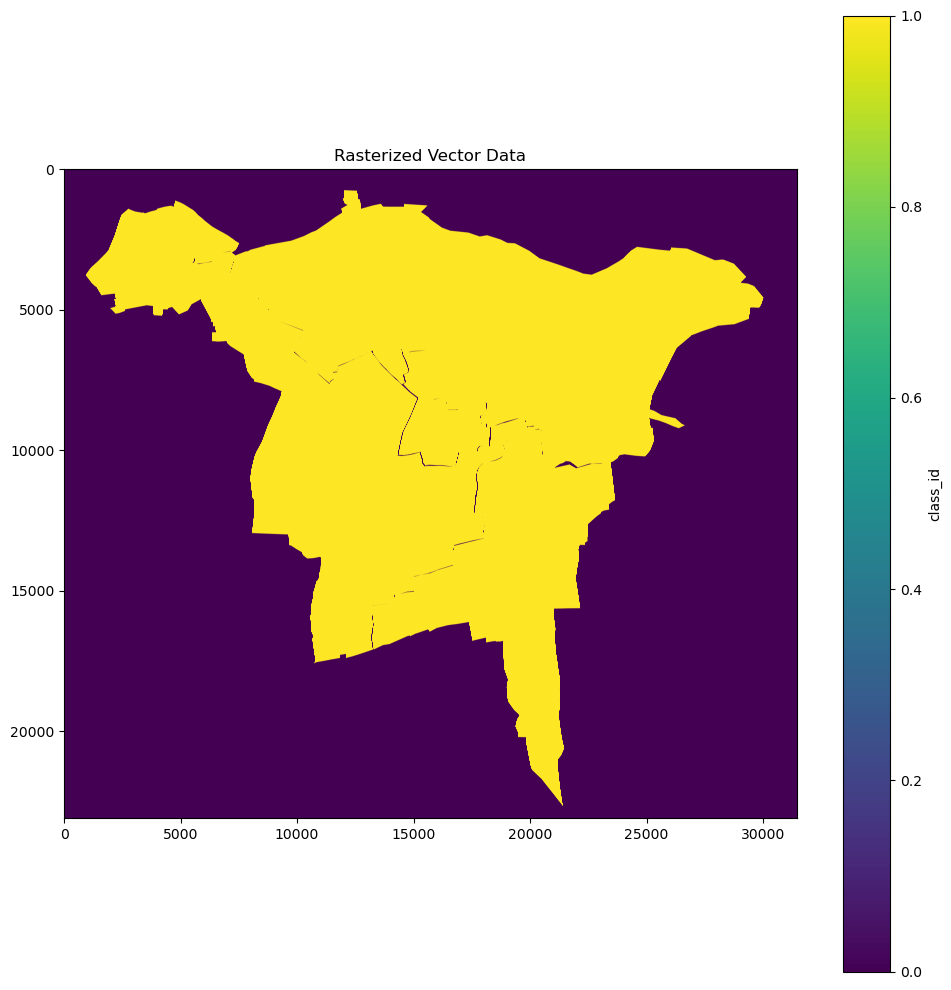

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(23080, 31447), dtype=uint8)

In [12]:
geoai.vector_to_raster(
    vector_path=vector_file,
    reference_raster=satellite_imagery,
    attribute_field='class_id',
    output_path='Labelraster_For_Unet_v4.tif',
    dtype='uint8',
    plot_result=True,
    nodata=0
    )

In [ ]:
geoai.view_raster('Labelraster_Manual.tif', cmap='tab20')

In [15]:
# Converting the gdf and  gdf_balanced to ee feature collection
crop_fc = geemap.gdf_to_ee(gdf)
crop_fc_balanced = geemap.gdf_to_ee(gdf_strat)

In [16]:
# Define a function to get imagery an apply filter
def get_imagery (start_date,end_date):
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    filtered_collection = collection.filterDate(start_date, end_date).filterBounds(crop_fc).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    median_image = filtered_collection.median().clip(crop_fc.geometry())
    return median_image


In [ ]:
# Seperate for Rabi  Season of the current year


def get_ndvindwi(median_image):
    # Calculate NDVI
    ndvi = median_image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    # McFeeters NDWI = (Green - NIR) / (Green + NIR)
    ndwi = median_image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return ndvi, ndwi

def get_mndwi(median_image):
    # Calculate MNDWI
    mndwi = median_image.normalizedDifference(['B3', 'B11']).rename('MNDWI')
    return mndwi

def get_savi(median_image):
    # Calculate Soil Adjusted Vetetation Index (SAVI)
    savi = median_image.expression(
        '(NIR - RED) / (NIR + RED + L) * (1 + L)', {
            'NIR': median_image.select('B8'),
            'RED': median_image.select('B4'),
            'L': 0.5
        }).rename('SAVI')
    return savi
def get_arvi(median_image):
    # Calculate Atmospherically Resistant Vegetation Index (ARVI)
    arvi = median_image.expression(
        '(NIR - (2 * RED - BLUE)) / (NIR + (2 * RED - BLUE))', {
            'NIR': median_image.select('B8'),
            'RED': median_image.select('B4'),
            'BLUE': median_image.select('B2')
        }).rename('ARVI')
    return arvi

def get_otherbands(median_image):
    # Adding other bans and calculating their mean
    bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
    band_img = median_image.select(bands).rename([f'{b}_mean' for b in bands])
    return band_img

def get_texture(median_image):
    # Calculating the texture
    nir_int = median_image.select('B8').toInt32()
    texture = nir_int.glcmTexture(size=3)
    contrast = texture.select('B8_contrast').rename('contrast')
    entropy = texture.select('B8_ent').rename('entropy')
    return contrast,entropy

def get_features(ndvi, ndwi, band_img, contrast, mndwi,entropy,savi,arvi):
    # Combine all features into a single image
    features_img = band_img.addBands([ndvi, ndwi,mndwi,entropy,savi,arvi])
    features_img = features_img.addBands(contrast)
    return features_img


In [101]:
#---------------------------
# Plan reduciton

def get_reduction(fc):
    # Step 2: Calculate mean NDVI for each agri polygon
    pcs = fc.reduceRegions(
    collection=crop_fc_balanced,
    reducer=ee.Reducer.mean(),
    scale=10,)
    # Convert the result to dataframe
    cf= geemap.ee_to_gdf(pcs)
    return cf



In [102]:
#----------------------------------
# Now calculate area, perimeter etc
def get_area(cropgdf):
# We need to calculate the area of each polygon in square meters
# Therefore we will convert the geometry to a projected coordinate system (EPSG:32643)
    cropgdf=cropgdf.to_crs(epsg=32643)
# Calculating the area , perimetere and compactness
    cropgdf['Area_m2'] = cropgdf.geometry.area
    cropgdf['Perimeter_m'] = cropgdf.geometry.length
    cropgdf['Compactness'] = (4 * 3.14 * cropgdf['Area_m2']) / (cropgdf['Perimeter_m'] ** 2)

# Switch back to lat/lon if needed for mapping
    cropgdf = cropgdf.to_crs(epsg=4326)

#Inspect the new columns
#gdfcrop_features[['Area_m2','Perimeter_m','Compactness']].head()
    return cropgdf



In [103]:
# Getting imagery and features
rabi = get_imagery('2024-10-01','2025-03-31')

ndvi_rabi, ndwi_rabi = get_ndvindwi(rabi)

savi_rabi = get_savi(rabi)

arvi_rabi = get_arvi(rabi)

mndwi_rabi = get_mndwi(rabi)    

band_rabi = get_otherbands(rabi)

contrast_rabi, entropy_rabi = get_texture(rabi)    

rabi_feats =   get_features(ndvi_rabi, ndwi_rabi,band_rabi, contrast_rabi,entropy_rabi,mndwi_rabi,savi_rabi,arvi_rabi)    



In [104]:
# Get reduction gdf for  Kharif_feas,rabi_feats and composite_features
rabi_reduced=get_reduction(rabi_feats)


In [105]:
#Get area, perimetetr and compactness for kharif_reduced,rabi_reduced and composite_reduced
rabi_reduced=get_area(rabi_reduced)


rabi_reduced['delta_NDVI'] = rabi_reduced['NDVI'] - rabi_reduced['NDVI_1']

In [106]:
rabi_reduced.columns

Index(['geometry', 'ARVI', 'Area_Acre', 'B11_mean', 'B12_mean', 'B2_mean',
       'B3_mean', 'B4_mean', 'B8_mean', 'Crop_Type', 'FFID', 'Landuse_Ma',
       'MNDWI', 'Mouza_Name', 'NDVI', 'NDWI', 'Parcel_ID', 'SAVI', 'contrast',
       'entropy', 'Area_m2', 'Perimeter_m', 'Compactness'],
      dtype='object')

In [107]:
rabi_reduced['Crop_Type'].value_counts()

Crop_Type
Persian Clover    82
Wheat             82
Barley            69
Garlic            69
Eucalyptus        69
Orchard           69
Potato            69
Name: count, dtype: int64

In [108]:
# List out the exact feature columns in your composite_reduced
feature_cols = [
    # early‑Kharif means (no “_1” suffix)
    'B2_mean', 'B3_mean', 'B4_mean', 'B8_mean', 'B11_mean', 'B12_mean','ARVI',
    'SAVI','NDVI', 'NDWI', 'contrast','MNDWI','entropy',
    
    # shape metrics (if present—you can add Area_Acre or Area_m2 etc.)
    'Area_m2','Perimeter_m','Compactness'       # or 'Area_m2','Perimeter_m','Compactness'
  
]


In [109]:
# Confirm target Class and features columns

print(rabi_reduced['Crop_Type'].value_counts())
print(rabi_reduced[feature_cols].value_counts())

Crop_Type
Persian Clover    82
Wheat             82
Barley            69
Garlic            69
Eucalyptus        69
Orchard           69
Potato            69
Name: count, dtype: int64
B2_mean     B3_mean      B4_mean      B8_mean      B11_mean     B12_mean     ARVI      SAVI      NDVI      NDWI       contrast       MNDWI      entropy   Area_m2      Perimeter_m  Compactness
541.846204  788.003286   779.887282   2418.290338  1652.071311  1191.102202  0.406829  0.766610  0.511153  -0.507069  94292.960745   -0.353062  4.331032  989.607358   149.857712   0.553470       69
625.893036  847.338054   979.838554   2118.323559  1721.361380  1364.426191  0.228597  0.552028  0.368078  -0.428703  10867.769511   -0.338140  4.335070  1949.881836  207.017949   0.571455       69
659.370318  904.737809   1001.175972  1953.619788  1859.055124  1500.055830  0.186054  0.483851  0.322622  -0.366973  11123.254399   -0.344852  4.285690  460.787680   129.001352   0.347778       35
676.094789  922.021340   1042.4

In [110]:
from sklearn.model_selection import train_test_split
# Splitting the data into training and testing sets

#Step 1 Define features (NDVI mean) and target label (Crop_Type)
X = rabi_reduced[feature_cols].values
y = rabi_reduced['Crop_Type'].values

# Train-test Split 80 % train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)



In [111]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred,zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
                precision    recall  f1-score   support

        Barley       1.00      1.00      1.00        14
    Eucalyptus       0.93      1.00      0.97        14
        Garlic       1.00      1.00      1.00        14
       Orchard       1.00      1.00      1.00        14
Persian Clover       0.93      0.88      0.90        16
        Potato       0.93      1.00      0.97        14
         Wheat       0.87      0.81      0.84        16

      accuracy                           0.95       102
     macro avg       0.95      0.96      0.95       102
  weighted avg       0.95      0.95      0.95       102

Confusion Matrix:
[[14  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0]
 [ 0  0 14  0  0  0  0]
 [ 0  0  0 14  0  0  0]
 [ 0  0  0  0 14  0  2]
 [ 0  0  0  0  0 14  0]
 [ 0  1  0  0  1  1 13]]


In [ ]:
rabi_reduced

In [122]:
# show me those records of rabi_reduced that prediction is different from the actual Crop_Type
diff = rabi_reduced[rabi_reduced['Crop_Type'] != rabi_reduced['pred']]
diff

,geometry,ARVI,Area_Acre,B11_mean,B12_mean,B2_mean,B3_mean,B4_mean,B8_mean,Crop_Type,...,NDVI,NDWI,Parcel_ID,SAVI,contrast,entropy,Area_m2,Perimeter_m,Compactness,pred
299,"POLYGON ((71.76047 34.01957, 71.76073 34.01904...",0.527841,1.028830,1675.379300,1076.317058,522.384291,775.090399,689.512987,2801.897200,Persian Clover,...,0.600248,-0.562776,725,0.900244,77733.890198,4.345630,4166.026128,272.406620,0.705142,Wheat
300,"POLYGON ((71.75593 34.02925, 71.75593 34.02905...",0.112545,1.122320,1918.902038,1641.451555,699.017733,941.780694,1193.876582,2102.544870,Persian Clover,...,0.277520,-0.381736,86,0.416217,11057.473316,4.317353,4544.654666,278.364921,0.736651,Wheat
445,"POLYGON ((71.76392 34.02308, 71.76397 34.02298...",0.106045,0.624940,1685.645178,1341.998973,662.477719,879.670733,1143.296006,2008.619366,Wheat,...,0.274570,-0.390756,477,0.411789,3035.607938,4.309255,2530.544987,235.176111,0.574668,Potato
449,"POLYGON ((71.76003 34.02746, 71.76028 34.02748...",0.451785,1.169670,1623.686835,1074.107292,477.497702,694.430267,676.281745,2361.149208,Wheat,...,0.547101,-0.540104,169,0.820516,101561.933690,4.322029,4736.328599,358.428455,0.463049,Eucalyptus
507,"POLYGON ((71.7625 34.01874, 71.7628 34.0184, 7...",0.546707,0.402284,1606.376097,1067.024940,484.612530,708.484038,617.067438,2628.333400,Wheat,...,0.609987,-0.567626,816,0.914839,124452.720035,4.341471,1628.960798,166.139837,0.741230,Persian Clover


In [123]:
# Add predictions to gdf_strat (or full set)
#['pred'] = rf_model.predict(gdf['Crop_Type'].values)

# Convert back to EE for mapping
#fc_pred = geemap.gdf_to_ee(gdf_strat, id_property='Parcel_ID')
#Map.addLayer(fc_pred.style(color='pred', palette='viridis'), {}, 'Predicted Crop Types')


# Save the model prediction to a geojson file
rabi_reduced.to_file("rabbi_crop_predictions.geojson", driver="GeoJSON")


In [124]:
#Export your model and features for reproducibility
#You can pickle your RF and the feature‐extraction parameters so that any future user can apply the exact same classification:

import joblib
joblib.dump({
    'model': rf_model,
    'feature_cols': feature_cols
}, 'crop_rf_pipeline.pkl')


['crop_rf_pipeline.pkl']

In [112]:
# Hyper Parameter Tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1) Define the parameter search space
param_dist = {
    'n_estimators':       [100, 200, 300, 400, 500],
    'max_depth':          [None, 10, 15, 20, 25],
    'min_samples_split':  [2, 5, 10],
    'min_samples_leaf':   [1, 2, 4, 6],
    'class_weight':       ['balanced', 'balanced_subsample']
}

# 2) Set up the RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,              # number of combinations to try
    scoring='f1_weighted',  # optimize for weighted F1
    cv=5,                   # 5‑fold cross‑validation
    n_jobs=-1,              # use all cores
    random_state=42,
    verbose=1
)

# 3) Run the search on your training data
rs.fit(X_train, y_train)

# 4) Inspect the best parameters
print("Best hyperparameters found:")
for k, v in rs.best_params_.items():
    print(f"  {k}: {v}")

# 5) Evaluate the best estimator on the test set
best_rf = rs.best_estimator_
y_pred = best_rf.predict(X_test)
print("\nClassification Report (best estimator):")
print(classification_report(y_test, y_pred, zero_division=0))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters found:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 1
  max_depth: 20
  class_weight: balanced

Classification Report (best estimator):
                precision    recall  f1-score   support

        Barley       1.00      1.00      1.00        14
    Eucalyptus       0.88      1.00      0.93        14
        Garlic       1.00      1.00      1.00        14
       Orchard       1.00      1.00      1.00        14
Persian Clover       0.93      0.81      0.87        16
        Potato       0.93      1.00      0.97        14
         Wheat       0.87      0.81      0.84        16

      accuracy                           0.94       102
     macro avg       0.94      0.95      0.94       102
  weighted avg       0.94      0.94      0.94       102



In [595]:

importances = rf_model.feature_importances_
for name, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{name}: {imp:.3f}")


B3_mean: 0.060
contrast_1: 0.054
B3_mean_1: 0.053
B11_mean: 0.048
B8_mean: 0.047
MNDWI: 0.045
B12_mean_1: 0.041
contrast: 0.040
B11_mean_1: 0.036
Perimeter_m: 0.035
MNDWI_1: 0.034
Area_Acre: 0.032
B12_mean: 0.032
B8_mean_1: 0.031
NDWI_1: 0.031
Compactness: 0.031
Area_m2: 0.030
B2_mean: 0.029
ARVI: 0.027
B4_mean: 0.027
B4_mean_1: 0.025
NDWI: 0.025
NDVI: 0.024
delta_NDVI: 0.024
entropy: 0.024
NDVI_1: 0.024
SAVI: 0.023
entropy_1: 0.022
SAVI_1: 0.022
ARVI_1: 0.021


In [834]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    rf_model, X, y, cv=5, scoring='f1_macro', n_jobs=-1
)
print("5‑fold F1_macro scores:", scores)
print("Mean:", scores.mean(), "Std:", scores.std())


5‑fold F1_macro scores: [0.92630082 0.90411156 0.97159832 0.94072997 0.94010879]
Mean: 0.9365698932627712 Std: 0.02198098357458017
